# モデルの学習

In [1]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import plotly.express as px
import re
import datetime as dt
import japanize_matplotlib
import itertools
year_pattern = r'([1-2][0-9]{3})'
import time

In [2]:
DATAPATH = "../../../data/DBLP/"
OUTPUTPATH = "../../../result/aminer/"

In [3]:
with open(DATAPATH + "keywords.txt") as f:
    keywords = list(map(lambda x: x.replace("\n", ""), f.readlines()))
key_sets = set(keywords)
len(keywords), keywords[0]

(2533, '3d imaging')

In [4]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import utils

from scipy.stats import pearsonr

In [5]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2276, 2276, 23), (2276, 2276), (2276, 2276, 23), (2276, 2276))

In [6]:
N = train_x.shape[0]
M = train_x.shape[2]
N, M

(2276, 23)

In [7]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2588950, 23), (2588950,), (2588950, 23), (2588950,))

In [8]:
P = train_x.shape[0]
P

2588950

In [9]:
model = LinearRegression()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))

フィッティング時間: 2.3206307739019394
スコア時間: 0.09810463339090347


In [10]:
result = model.predict(test_x)
result_before = model.predict(train_x)
result.shape, result_before.shape

((2588950,), (2588950,))

In [11]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 10.94, MSE: 119.68, 相関係数: 0.822


In [12]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 5.369, MSE: 28.827, 相関係数: 0.62


In [13]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=False)
df["実測順位"] = df["実測"].rank(ascending=False)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.43

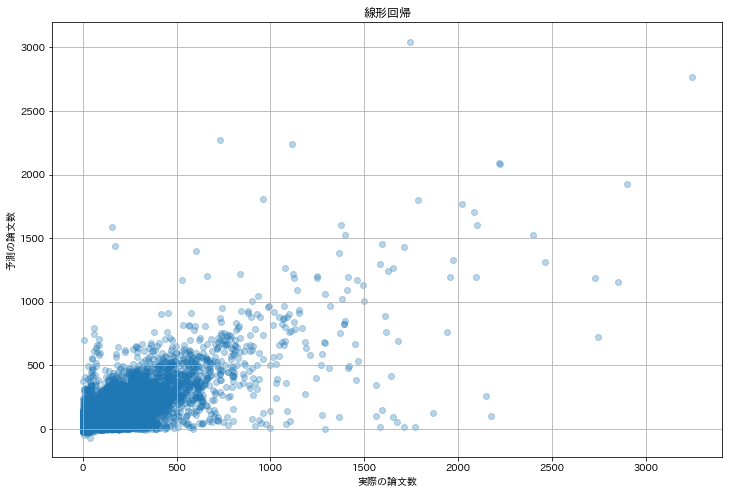

In [14]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.show()

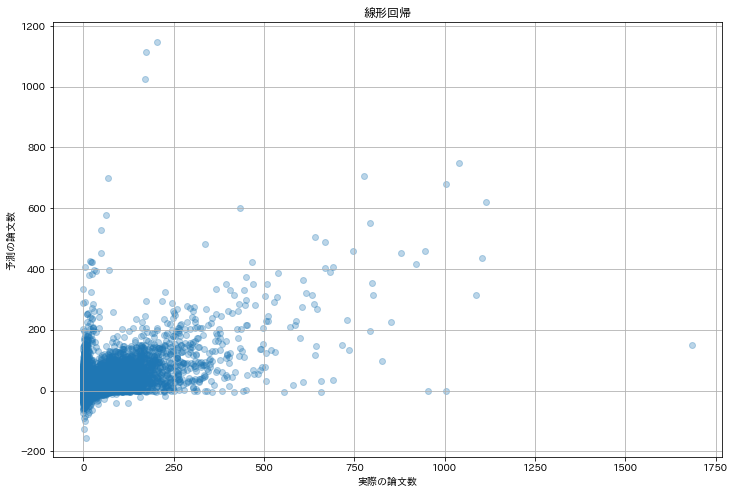

In [15]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr.png")
fig.show()

In [16]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if x[i][j] > 400:
            print(word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

['accessibility' 'energy efficient'] 423.7 24.0
['agents' 'data model'] 1026.4 171.0
['agents' 'electromagnetic interference'] 700.0 68.0
['agents' 'muscle'] 1146.3 203.0
['aging' 'modulation'] 424.2 466.0
['beamforming' 'binary codes'] 406.0 6.0
['breast cancer' 'self organization'] 488.3 669.0
['communication channels' 'cost function'] 458.7 947.0
['communication channels' 'jitter'] 681.4 1003.0
['data compression' 'distributed systems'] 402.5 670.0
['data model' 'electromagnetic interference'] 527.6 48.0
['data model' 'genetic algorithms'] 423.8 20.0
['data model' 'muscle'] 1113.6 173.0
['edge detection' 'memory bandwidth'] 425.9 18.0
['electromagnetic interference' 'muscle'] 578.4 63.0
['energy efficient' 'secondary structure'] 460.9 746.0
['energy efficient' 'stochastic optimization'] 453.4 878.0
['human-robot interaction' 'position control'] 417.6 922.0
['human-robot interaction' 'question answering'] 747.7 1040.0
['human-robot interaction' 'system architecture'] 550.8 794.0
['kn

In [17]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if correct_matrix[i][j] > 400:
            print( word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

['aging' 'modulation'] 424.2 466.0
['amplify and forward communicatio' 'communication channels'] 118.3 640.0
['amplify and forward communicatio' 'cost function'] 76.7 494.0
['amplify and forward communicatio' 'jitter'] 123.0 505.0
['application software' 'human-robot interaction'] 173.3 427.0
['approximation' 'interference cancellation'] 66.8 490.0
['bayes methods' 'channel bank filters'] 330.9 407.0
['brain' 'energy efficient'] 53.3 472.0
['breast cancer' 'self organization'] 488.3 669.0
['cameras' 'linear codes'] 14.8 402.0
['case-based reasoning' 'interference cancellation'] 127.9 531.0
['channel bank filters' 'communication channels'] 153.6 496.0
['channel bank filters' 'communication technology'] 207.7 497.0
['channel bank filters' 'hybrid system'] 195.4 794.0
['channel bank filters' 'position control'] 173.6 601.0
['channel bank filters' 'public administration'] 314.2 803.0
['communication channels' 'cost function'] 458.7 947.0
['communication channels' 'energy efficient'] 230.4 

In [18]:
# weight = np.where(train_y == 0.0, True, False)  # if target == 0 : True else: False
# weight_inv = np.where(weight, False, True) # if target == 0 : False else: True

# # 0と1以上のデータを同数にする
# train_x_0, train_y_0 = train_x[weight], train_y[weight]
# train_x_1, train_y_1 = train_x[weight_inv], train_y[weight_inv]
# train_x_0, train_y_0 = utils.shuffle(train_x_0, train_y_0)
# train_x_0, train_y_0 = train_x_0[:len(train_x_1)], train_y_0[:len(train_y_1)]
# train_x, train_y = np.concatenate([train_x_0, train_x_1]), np.concatenate([train_y_0, train_y_1])

# print(train_x.shape, train_y.shape)
# print("0のデータ数: {}, 1以上のデータ数: {}".format(len(train_x_0), len(train_x_1)))

# 人気度

In [19]:
train_x = np.load(DATAPATH + "train_x.npy")
train_y = np.load(DATAPATH + "train_y_diff.npy")

test_x = np.load(DATAPATH + "test_x.npy")
test_y = np.load(DATAPATH + "test_y_diff.npy")
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2276, 2276, 23), (2276, 2276), (2276, 2276, 23), (2276, 2276))

In [20]:
train_x, train_y, test_x, test_y = train_x[np.triu_indices(n=N, k=1)], train_y[np.triu_indices(n=N, k=1)], test_x[np.triu_indices(n=N, k=1)], test_y[np.triu_indices(n=N, k=1)]
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((2588950, 23), (2588950,), (2588950, 23), (2588950,))

In [21]:
model = LinearRegression()
start_time = time.perf_counter()
model.fit(train_x, train_y)
print("フィッティング時間: {}".format(time.perf_counter() - start_time))
start_time = time.perf_counter()
model.score(test_x, test_y)
print("スコア時間: {}".format(time.perf_counter() - start_time))
result = model.predict(test_x)
result_before = model.predict(train_x)

フィッティング時間: 1.9251322820782661
スコア時間: 0.07873880118131638


In [22]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result_before, train_y)),3), 
    round(mean_squared_error(result_before, train_y),3),
    round(pearsonr(result_before, train_y)[0],3)))

RMSE: 10.94, MSE: 119.68, 相関係数: 0.751


In [23]:
print("RMSE: {}, MSE: {}, 相関係数: {}".format(
    round(np.sqrt(mean_squared_error(result, test_y)),3), 
    round(mean_squared_error(result, test_y),3),
    round(pearsonr(result, test_y)[0],3)))

RMSE: 5.369, MSE: 28.827, 相関係数: 0.954


In [24]:
df = pd.DataFrame(result, columns=["予測"])
df["実測"] = test_y
df["予測順位"] = df["予測"].rank(ascending=True)
df["実測順位"] = df["実測"].rank(ascending=True)
df = df.sort_values("予測順位", )
top = df.head(100)
len(top[top["実測順位"]<100]) / len(top)

0.83

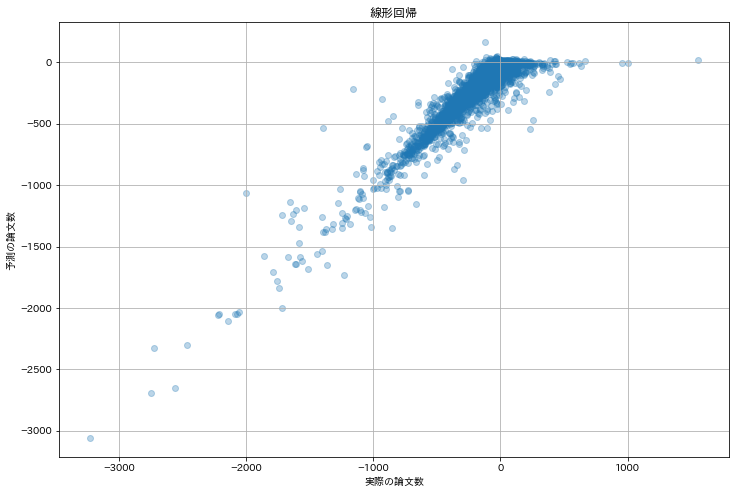

In [25]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(test_y, result, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
fig.savefig(OUTPUTPATH+"img/lr_diff.png")
fig.show()

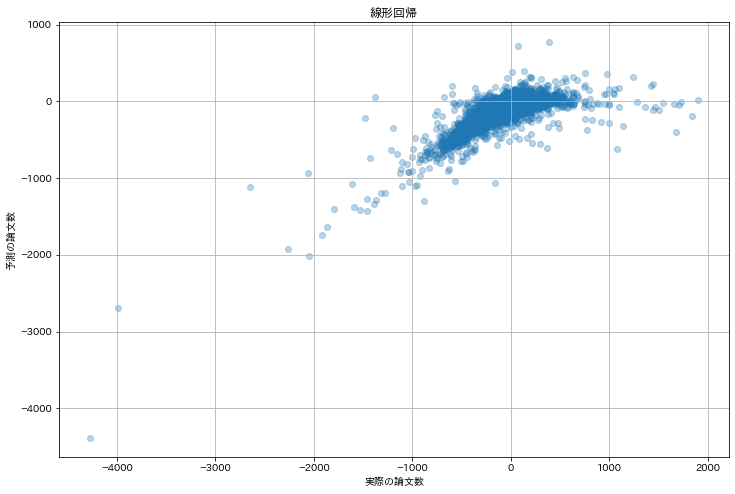

In [26]:
fig, ax = plt.subplots(facecolor="white",figsize=(12,8))
ax.scatter(train_y, result_before, alpha=0.3)
ax.set_xlabel("実際の論文数")
ax.set_ylabel("予測の論文数")
ax.grid()
ax.set_title("線形回帰")
# fig.savefig(OUTPUTPATH+"img/gbm.png")
fig.show()

In [27]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if x[i][j] < -1500:
            print(word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

['agents' 'beamforming'] -3055.1 -3231.0
['agents' 'level of detail'] -2057.1 -2223.0
['aggregation' 'aging'] -2105.1 -2145.0
['beamforming' 'binary codes'] -2323.0 -2723.0
['beamforming' 'level of detail'] -2045.5 -2217.0
['channel bank filters' 'polynomials'] -1562.7 -1445.0
['channel bank filters' 'static analysis'] -1683.2 -1517.0
['client server' 'client-server systems'] -1645.3 -1615.0
['communication channels' 'complete graph'] -2691.4 -2747.0
['energy efficient' 'gold'] -2648.7 -2556.0
['energy efficient' 'graphical model'] -1727.4 -1228.0
['energy efficient' 'information content'] -1783.9 -1755.0
['energy efficient' 'secondary structure'] -2003.1 -1718.0
['engineering management' 'extended kalman filter'] -2052.2 -2088.0
['gold' 'secondary structure'] -1582.6 -1573.0
['human-robot interaction' 'question answering'] -1653.3 -1361.0
['information content' 'interference cancellation'] -2036.3 -2054.0
['information content' 'secondary structure'] -1615.3 -1564.0
['linearity' 'link

In [28]:
word_matrix = np.zeros([N,N,2]).astype(str)
correct_matrix = np.zeros([N,N])
for i in range(N):
    for j in range(N):
        word_matrix[i][j][0] = keywords[i]
        word_matrix[i][j][1] = keywords[j]
x = np.zeros([N,N]) 
correct_matrix[np.triu_indices(n=N, k=1)] = test_y
x[np.triu_indices(n=N, k=1)] = model.predict(test_x)
for i in range(N):
    for j in range(N):
        if correct_matrix[i][j] < -1500:
            print(i, j, word_matrix[i][j], round(x[i][j],1), correct_matrix[i][j])

10 733 ['accessibility' 'energy efficient'] -1231.3 -1631.0
39 149 ['agents' 'beamforming'] -3055.1 -3231.0
39 1268 ['agents' 'level of detail'] -2057.1 -2223.0
40 41 ['aggregation' 'aging'] -2105.1 -2145.0
149 163 ['beamforming' 'binary codes'] -2323.0 -2723.0
149 1268 ['beamforming' 'level of detail'] -2045.5 -2217.0
251 2203 ['channel bank filters' 'static analysis'] -1683.2 -1517.0
271 272 ['client server' 'client-server systems'] -1645.3 -1615.0
319 333 ['communication channels' 'complete graph'] -2691.4 -2747.0
500 702 ['data model' 'electromagnetic interference'] -1240.4 -1720.0
500 1234 ['data model' 'knowledge base'] -1290.5 -1650.0
500 1525 ['data model' 'muscle'] -1059.4 -2000.0
702 1234 ['electromagnetic interference' 'knowledge base'] -1189.5 -1548.0
702 1525 ['electromagnetic interference' 'muscle'] -1135.6 -1651.0
733 956 ['energy efficient' 'gold'] -2648.7 -2556.0
733 1126 ['energy efficient' 'information content'] -1783.9 -1755.0
733 2014 ['energy efficient' 'secondary